## File: onet_task_adjacency.ipynb
#### Summary: Explores ONET data to motivate th Agentic AI model

#### By: Peyman Shahidi
#### Created: Jan 15, 2025

In [1]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
main_folder_path = ".."
data_path = f"{main_folder_path}/data"
output_path = f"{main_folder_path}/writeup/plots/"

### Main Code Starts Here

<br>

## Section (1)

In [3]:
# Read O*NET data
onet = pd.read_csv(f'{data_path}/onet_occupations_yearly.csv')

# keep 2023 entries only
onet = onet[onet['year'] == 2023].reset_index(drop=True)

# keep occupation, task, work activity, and detailed work activity columns
onet = onet[['occ_code', 'occ_title', 'task_id', 'task', 'wa_id', 'wa_name', 'dwa_id', 'dwa_title']]
onet = onet.sort_values(by=['occ_code', 'task_id', 'wa_id', 'dwa_id']).reset_index(drop=True)

# remove 's for consistency issues 
onet = onet.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

In [4]:
# Print ONET stats
print(f'Number of unique occupation-task pairs in ONET data: {len(onet)}\n')

print(f'Number of unique occupations in ONET data: {len(onet["occ_title"].unique())}\n')

print(f'Number of unique tasks in ONET data: {len(onet["task_id"].unique())}')
print(f'Number of unique work activities in ONET data: {len(onet["wa_id"].unique())}')
print(f'Number of unique detailed work activities in ONET data: {len(onet["dwa_id"].unique())}')

Number of unique occupation-task pairs in ONET data: 24426

Number of unique occupations in ONET data: 798

Number of unique tasks in ONET data: 19294
Number of unique work activities in ONET data: 38
Number of unique detailed work activities in ONET data: 2086


In [5]:
# Variables to work with
task_variable = 'dwa_title'
occupation_variable = 'occ_title'

# Remove duplicates in terms of occupation-task pairs
onet = onet.drop_duplicates(subset=[occupation_variable, task_variable])

# Other data cleanins
onet.replace("NaN", np.nan, inplace=True)
onet.dropna(how='any', inplace=True)

### Create task-task co-occurrence matrix

In [6]:
def create_task_task_cooc_matrix(df, 
                                 occupation_variable,
                                 task_variable):

    # Keep only the relevant columns
    df = df[[task_variable, occupation_variable]].dropna(subset=[task_variable, occupation_variable])

    # Rename for consistency
    df = df.rename(columns={task_variable: 'task',
                            occupation_variable: 'occupation'})

    # 1. Get unique tasks
    unique_tasks = df['task'].unique()
    
    # 2. Map each task to the set of occupations that have that task
    task_to_occupations = defaultdict(set)
    for row in df.itertuples(index=False):
        task_to_occupations[row.task].add(row.occupation)
    
    # 3. Prepare an empty DataFrame for the output matrix
    cooc_matrix = pd.DataFrame(
        index=unique_tasks, 
        columns=unique_tasks, 
        dtype=float
    )
    
    # 4. Calculate ratio for each pair (t1, t2)
    for t1 in unique_tasks:
        occ_set_t1 = task_to_occupations[t1]
        for t2 in unique_tasks:
            occ_set_t2 = task_to_occupations[t2]

            # Intersection: occupations containing both t1 and t2
            intersection = occ_set_t1.intersection(occ_set_t2)
            
            # Denominator: number of unique occupations containing either t1 or t2
            denom = len(occ_set_t1) + len(occ_set_t2) - len(intersection)

            # Handle zero-denominator case
            ratio = 0.0 if denom == 0 else len(intersection) / denom
            
            cooc_matrix.at[t1, t2] = ratio
    
    return cooc_matrix


cooccurrence_matrix = create_task_task_cooc_matrix(onet, occupation_variable, task_variable) # in dataframe format
cooccurrence_matrix.to_csv(f'{output_path}/task_task_cooccurrence_matrix.csv', index=True)

#### Get individual task co-occurrence score

In [7]:
# Create a boolean mask that is True on the diagonal
diagonal_mask = np.eye(len(cooccurrence_matrix), dtype=bool)

# Use .mask() to replace diagonal cells with NaN
cooccurrence_matrix_no_diag = cooccurrence_matrix.mask(diagonal_mask)

# Compute row means, skipping NaN values
task_scores_df = cooccurrence_matrix_no_diag.mean(axis=1)

# Sort the row means in descending order
task_scores_df.sort_values(ascending=False)
task_scores_df = task_scores_df.rename_axis(occupation_variable).reset_index(name='cooccurrence_score')

# Save the sorted row means to a CSV file
task_scores_df.to_csv(f'{output_path}/indiv_task_cooccurrence_scores.csv', header=False)

#### Get occupation co-occurrence scores

In [8]:
def compute_cooccurrence_scores(df, cooccurrence_matrix, occupation_variable, task_variable):

    # 1. Create a mapping of occupation -> set/list of tasks
    occ_to_tasks = df.groupby(occupation_variable)[task_variable].unique().to_dict()

    # 2. For each occupation, subset the co-occurrence matrix and compute the score
    cooccurrence_scores = {}
    for occ, tasks in occ_to_tasks.items():
        tasks = list(tasks)  # Ensure it's a list (instead of a numpy array)

        # Subset the co-occurrence matrix for tasks in this occupation.
        # Only include tasks that actually appear in cooccurrence_matrix's index (and columns).
        valid_tasks = [t for t in tasks if t in cooccurrence_matrix.index]
        if len(valid_tasks) < 2:
            # If only 0 or 1 tasks are present, the off-diagonal sum is trivially 0
            cooccurrence_scores[occ] = 0.0
            continue

        submatrix = cooccurrence_matrix.loc[valid_tasks, valid_tasks]

        # 3. Sum of all elements in the submatrix
        total_sum = submatrix.values.sum()

        # 4. Subtract the diagonal to get only off-diagonal elements
        diag_sum = np.trace(submatrix.values)
        off_diag_sum = total_sum - diag_sum

        # 5. Since the matrix is symmetric, each pair (i, j) is counted twice in off_diag_sum
        cooccurrence_score = off_diag_sum / 2 / len(valid_tasks) / (len(valid_tasks) - 1)

        cooccurrence_scores[occ] = cooccurrence_score

    return cooccurrence_scores



# Compute co-occurrence scores for each occupation
occupation_scores = compute_cooccurrence_scores(
    onet, 
    cooccurrence_matrix, 
    occupation_variable, 
    task_variable
)

# Create dataframe from the scores
occupation_scores_df = pd.DataFrame(occupation_scores.items(), columns=[occupation_variable, 'cooccurrence_score'])
occupation_scores_df = occupation_scores_df.sort_values(by=['cooccurrence_score'], ascending=False)
occupation_scores_df.to_csv(f'{output_path}/indiv_occupation_cooccurrence_scores.csv', index=False)

### Plot individual occupation co-occurrence score and individual task co-occurrence score histograms

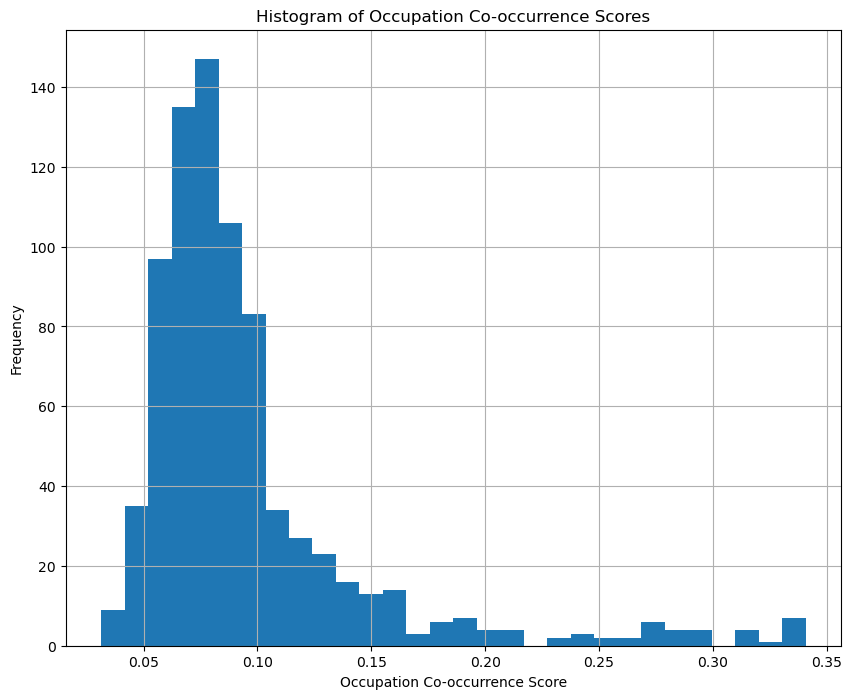

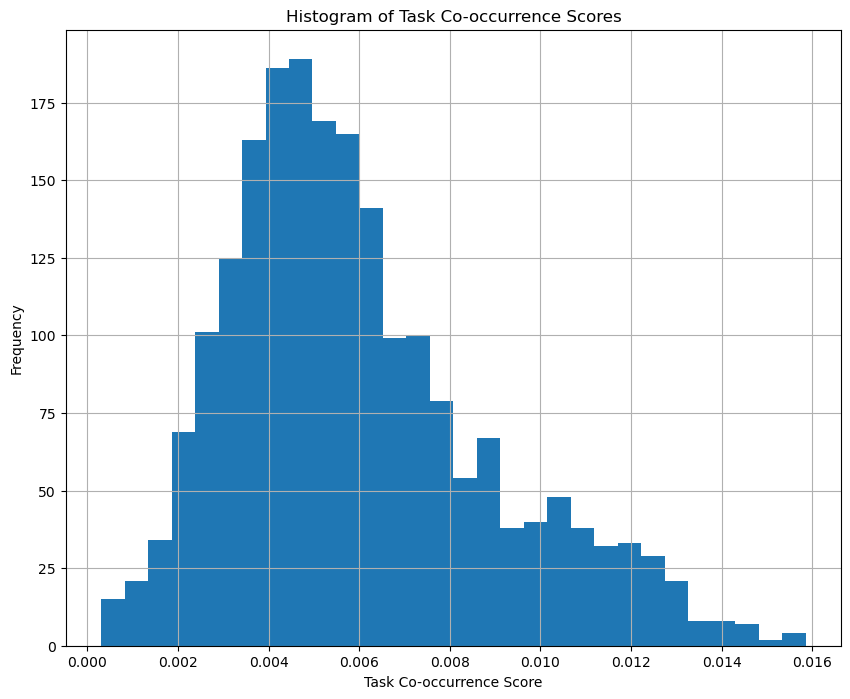

In [9]:
# Plot histogram of co-occurrence scores
# Occupation scores
fig, ax = plt.subplots(figsize=(10, 8))
occupation_scores_df['cooccurrence_score'].hist(bins=30, ax=ax)
ax.set_title(f'Histogram of Occupation Co-occurrence Scores')
ax.set_xlabel('Occupation Co-occurrence Score')
ax.set_ylabel('Frequency')
plt.savefig(f'{output_path}/indiv_occupation_cooccurrence_score_histogram.png', dpi=300)
plt.show()

# Task Scores
fig, ax = plt.subplots(figsize=(10, 8))
task_scores_df['cooccurrence_score'].hist(bins=30, ax=ax)
ax.set_title('Histogram of Task Co-occurrence Scores')
ax.set_xlabel('Task Co-occurrence Score')
ax.set_ylabel('Frequency')
plt.savefig(f'{output_path}/indiv_task_cooccurrence_score_histogram.png', dpi=300)
plt.show()


## Section 2

<br>

### Get non-weighted task pair repetition score

In [10]:
def count_task_pairs(df, occupation_variable, task_variable):
    # Ensure both columns are string-typed before sorting
    df[occupation_variable] = df[occupation_variable].astype(str)
    df[task_variable] = df[task_variable].astype(str)
    
    # Step 1: Sort (if desired) and build a mapping: occupation -> set of tasks
    # Sorting is optional here since sets ignore order, but kept for completeness
    df_sorted = df.sort_values(by=[occupation_variable, task_variable])
    occ_to_tasks = (
        df_sorted
        .groupby(occupation_variable)[task_variable]
        .apply(set)
        .to_dict()
    )

    # Step 2: Initialize a dictionary to count pairs
    pair_counts = defaultdict(int)

    # Step 3: For each occupation, find all pairs of tasks and increment the counter
    for occ, tasks in occ_to_tasks.items():
        # Get all unique combinations of 2 tasks within this occupation
        for t1, t2 in itertools.combinations(tasks, 2):
            # Sort or tuple them consistently if you want to avoid directionality
            pair = tuple(sorted((t1, t2)))
            pair_counts[pair] += 1

    return pair_counts

def pair_counts_to_matrix(pair_counts):
    # Extract all unique tasks from the keys
    tasks = set()
    for (t1, t2) in pair_counts.keys():
        tasks.add(t1)
        tasks.add(t2)
    tasks = sorted(tasks)  # for a consistent ordering

    # Create an empty DataFrame
    matrix = pd.DataFrame(0, index=tasks, columns=tasks, dtype=int)

    # Fill the DataFrame with counts
    for (t1, t2), count in pair_counts.items():
        matrix.at[t1, t2] = count
        matrix.at[t2, t1] = count  # make it symmetric

    return matrix


# Count how many occupations each pair of tasks appears in
pair_counts_dict = count_task_pairs(onet, occupation_variable, task_variable)
pair_counts_df = pd.DataFrame(
    [(t1, t2, count) for (t1, t2), count in pair_counts_dict.items()],
    columns=['Task1', 'Task2', 'Count']
)
pair_counts_df = pair_counts_df.sort_values(by='Count', ascending=False)

# Save to csv
pair_counts_df.to_csv(f'{output_path}/task_pair_counts.csv', index=False)

### Plot non-weighted task pair repetition score

Length of task pair counts: 109032
Length of task pair counts w/ >15 repeats: 521


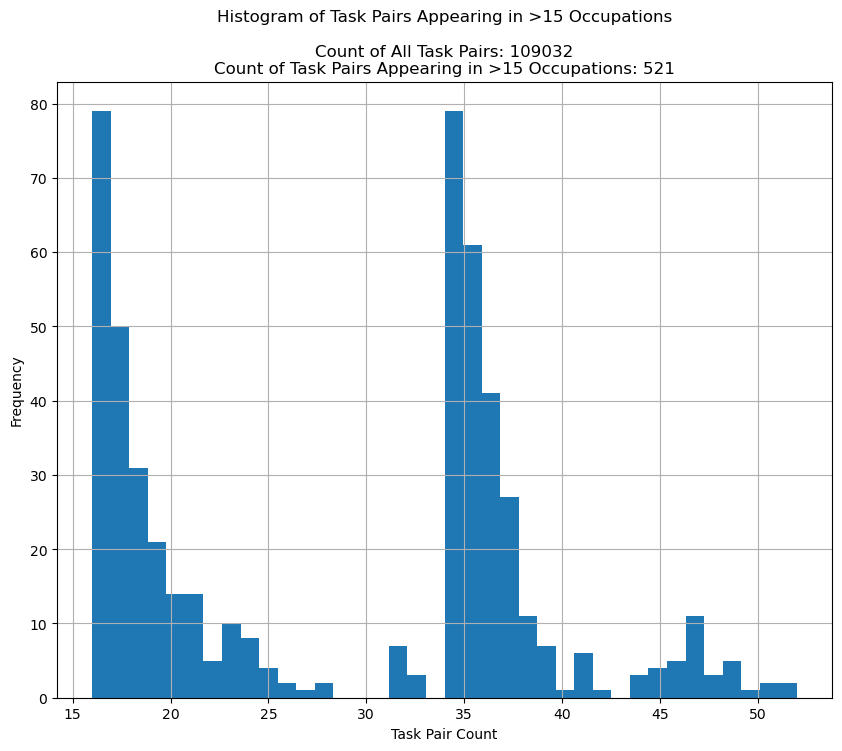

In [11]:
truncation_threhsold = 15
truncated_pair_counts = pair_counts_df[pair_counts_df.Count > truncation_threhsold]

print(f'Length of task pair counts: {len(pair_counts_df)}')
print(f'Length of task pair counts w/ >{truncation_threhsold} repeats: {len(truncated_pair_counts)}')

n_bins = truncated_pair_counts.Count.max() - truncation_threhsold + 1

# Plot task pair counts
fig, ax = plt.subplots(figsize=(10, 8))
truncated_pair_counts['Count'].hist(bins=n_bins, ax=ax)
ax.set_title(f'Histogram of Task Pairs Appearing in >{truncation_threhsold} Occupations\n\nCount of All Task Pairs: {len(pair_counts_df)}\nCount of Task Pairs Appearing in >{truncation_threhsold} Occupations: {len(truncated_pair_counts)}')
ax.set_xlabel('Task Pair Count')
ax.set_ylabel('Frequency')
plt.savefig(f'{output_path}/task_pair_counts_histogram.png', dpi=300)
plt.show()

In [12]:
## So many "Teacher"s! ##

# 1. Filter rows where occupation column contains 'teacher' (case-insensitive).
df_teachers = onet[onet['occ_title'].str.contains('Teacher', case=False, na=False)]

# 2. Extract unique occupation names from the filtered DataFrame.
teacher_occupations = df_teachers['occ_title'].unique().tolist()
len(teacher_occupations)

50

## Section 3

<br>

### Get Occupation Task Overlap (a.k.a. Occupation Similarity Score)

In [13]:
def create_occupation_similarity_matrix(onet, occupation_variable, task_variable):
    # 1. Create a mapping from occupation -> set of tasks
    occ_to_tasks = onet.groupby(occupation_variable)[task_variable].apply(set).to_dict()

    # 2. Gather all unique occupations
    all_occupations = list(occ_to_tasks.keys())

    # 3. Initialize a square DataFrame for the similarity matrix
    similarity_matrix = pd.DataFrame(
        0.0,
        index=all_occupations,
        columns=all_occupations
    )

    # 4. Compute ratio of (# common tasks) to (# unique tasks) for each pair of occupations
    for occ1 in all_occupations:
        tasks1 = occ_to_tasks[occ1]
        for occ2 in all_occupations:
            tasks2 = occ_to_tasks[occ2]

            common_tasks = tasks1.intersection(tasks2)
            all_unique_tasks = tasks1.union(tasks2)

            if len(all_unique_tasks) == 0:
                ratio = 0.0
            else:
                ratio = len(common_tasks) / len(all_unique_tasks)

            similarity_matrix.at[occ1, occ2] = ratio

    return similarity_matrix

# Generate the occupation similarity matrix
occupation_overlap_df = create_occupation_similarity_matrix(onet, occupation_variable, task_variable)

# Save the occupation overlap matrix to a CSV file
occupation_overlap_df.to_csv(f'{output_path}/occupation_similarity_matrix.csv', index=True)

### Get occupation-similarity-weighted task pair repetition score

In [14]:
def weighted_task_pairs_count(df, occupation_variable, task_variable, occupation_overlap_df):
    """
    For each pair of tasks, this function:
      1) Gathers all occupations that have both tasks.
      2) Subsets occupation_overlap_df to those occupations (rows & columns).
      3) Inverts the submatrix and averages the off-diagonal entries in the upper triangle.
      4) Returns a DataFrame with columns:
         [Task1, Task2, Weighted_Count, Num_Occupations, Avg_Occupation_Task_Count, Occupations_List].
    """

    # 1. Build a mapping: occupation -> set of tasks
    occ_to_tasks = df.groupby(occupation_variable)[task_variable].apply(set).to_dict()

    # 2. For each pair of tasks, gather the occupations that have both
    pair_to_occupations = defaultdict(set)
    for occ, tasks in occ_to_tasks.items():
        for t1, t2 in itertools.combinations(tasks, 2):
            pair = tuple(sorted((t1, t2)))
            pair_to_occupations[pair].add(occ)

    results = []
    # 3. Process each pair to compute Weighted_Count & average task count for those occupations
    for (t1, t2), occs in pair_to_occupations.items():
        occs_list = list(occs)

        # -- Weighted_Count (average off-diagonal in the inverted submatrix)
        if len(occs_list) < 2:
            count_value = 0.0
        else:
            submatrix = occupation_overlap_df.loc[occs_list, occs_list].values
            inverted_submatrix = 1 / submatrix

            # Replace inf/-inf with 0 to avoid errors
            inverted_submatrix[np.isinf(inverted_submatrix)] = 0

            r, c = np.triu_indices(n=inverted_submatrix.shape[0], k=1)
            upper_tri_values = inverted_submatrix[r, c]
            count_value = np.mean(upper_tri_values)

        # -- Average number of tasks across these occupations
        if len(occs_list) > 0:
            avg_occ_task_count = np.mean([len(occ_to_tasks[o]) for o in occs_list])
        else:
            avg_occ_task_count = 0.0

        # 4. Append the row to results:
        #    (Task1, Task2, Weighted_Count, Num_Occupations, Avg_Occupation_Task_Count, Occupations_List)
        results.append((t1, t2, count_value, len(occs_list), avg_occ_task_count, occs_list))

    # 5. Create a DataFrame with the extended columns
    df_results = pd.DataFrame(results, columns=["Task1", "Task2", "Weighted_Count", "Num_Occupations", "Avg_Occupation_Task_Count", "Occupations_List"])
    return df_results


# Run function
weighted_pairs_df = weighted_task_pairs_count(
    onet,
    occupation_variable,
    task_variable,
    occupation_overlap_df=occupation_overlap_df
)

# Remove zeros
weighted_pairs_df = weighted_pairs_df[weighted_pairs_df['Weighted_Count'] > 0]

# Sort by count
weighted_pairs_df = weighted_pairs_df.sort_values(by='Weighted_Count', ascending=False)

# Save the results
weighted_pairs_df.to_csv(f'{output_path}/task_pair_weightedScores.csv', index=False)
weighted_pairs_df

,Task1,Task2,Weighted_Count,Num_Occupations,Avg_Occupation_Task_Count,Occupations_List
34183,Assign duties or work schedules to employees.,"Maintain records, documents, or other files.",75.50,2,76.50,"[Personal Service Managers, All Other, Compute..."
32398,Discuss design or technical features of produc...,"Evaluate potential of products, technologies, ...",74.00,2,75.00,"[Sales Representatives, Wholesale and Manufact..."
32656,Develop organizational policies or programs.,"Search files, databases or reference materials...",73.00,2,74.00,"[Secretaries and Administrative Assistants, Ex..."
30356,Document operational activities.,Record images needed to address work issues.,70.00,2,71.00,"[Radio, Cellular, and Tower Equipment Installe..."
30560,Prepare technical or operational reports.,Testify at legal or legislative proceedings.,69.50,2,70.50,"[Health and Safety Engineers, Except Mining Sa..."
...,...,...,...,...,...,...
103358,Supervise laboratory work.,Support the professional development of others.,1.00,2,28.00,"[Sociology Teachers, Postsecondary, Social Wor..."
103357,Advise others on career or personal development.,Maintain student records.,1.00,2,28.00,"[Sociology Teachers, Postsecondary, Social Wor..."
103361,Advise others on career or personal development.,Teach social science courses at the college le...,1.00,2,28.00,"[Sociology Teachers, Postsecondary, Social Wor..."
103356,Maintain student records.,Support the professional development of others.,1.00,2,28.00,"[Sociology Teachers, Postsecondary, Social Wor..."


### Plot the best of both worlds: filter for number of occupations in weighted scores version

Length of task pair counts: 43415
Length of task pair counts w/ >10 repeats: 1269


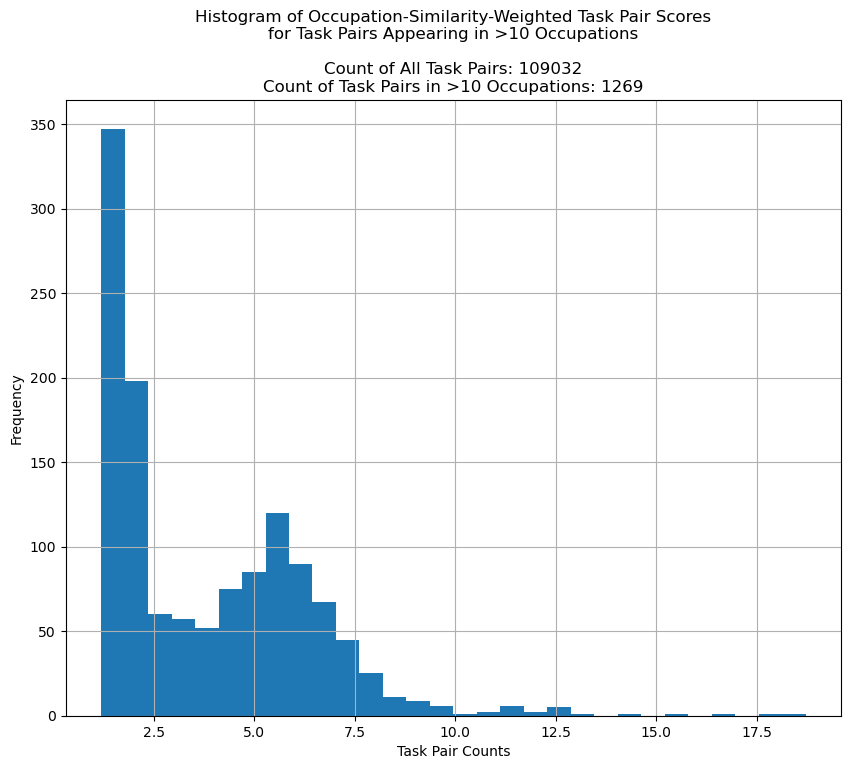

In [15]:
# Filter 1) by weighted count and 2) by number of occupations
# 1)
truncation_threhsold = 0
truncated_pair_counts = weighted_pairs_df[weighted_pairs_df.Weighted_Count > truncation_threhsold]

# 2)
num_occs_threshold = 10
truncated_pair_counts = truncated_pair_counts[truncated_pair_counts.Num_Occupations > num_occs_threshold]

# Print Stats
print(f'Length of task pair counts: {len(weighted_pairs_df)}')
print(f'Length of task pair counts w/ >{num_occs_threshold} repeats: {len(truncated_pair_counts)}')


# Plot weighted task pair count
fig, ax = plt.subplots(figsize=(10, 8))
truncated_pair_counts['Weighted_Count'].hist(bins=30, ax=ax)
ax.set_title(f'Histogram of Occupation-Similarity-Weighted Task Pair Scores\nfor Task Pairs Appearing in >{num_occs_threshold} Occupations\n\nCount of All Task Pairs: {len(pair_counts_df)}\nCount of Task Pairs in >{num_occs_threshold} Occupations: {len(truncated_pair_counts)}')
ax.set_xlabel('Task Pair Counts')
ax.set_ylabel('Frequency')
plt.savefig(f'{output_path}/task_pair_weightedScore_histogram.png', dpi=300)
plt.show()